<a href="https://colab.research.google.com/github/argennof/M_Predi_Lluvias_Extremas_10/blob/main/Resultados_p3/TP3_Balbuena_Serrantes_Fonnegra_Velazquez_todas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TP3: Introducción al aprendizaje automático

De los datasets analizados en los TPs anteriores, ahora nos vamos a enfocar en:

- La Florida
- Marcos Juarez

Y vamos a usar como variable que queremos predecir, la PMDA que han calculado para cada año hidrológico (del 1/julio al 30/junio).

Las demás variables (como viento, temperatura, etc) las vamos a resumir para cada año hidrológico en la media (se pueden agregar más estadísticos pero así es suficiente).

##### Actividades:

##### OBJETIVO: Predecir Precipitación Máxima Diaria Anual (PMDA) para los próximos 5 años

1) De los dataset que han trabajado hasta ahora, agreguen más features al DataFrame **"Datos"** (Por lo general, más features tienden a dar mejores predicciones).

2) Además de las features del punto anterior, les propongo agregar nuevas features moviendo las originales tantos "pasos de tiempo" como features nuevas quieran generar.

3) Curar el dataset (si fuera necesario).

4) Aplicar técnicas de selección y extraccion de features. Armar un nuevo dataset con aquellas features más significativas.

5) Dividir el dataset (training, validation, test).. Recuerden que queremos predecir la PMDA para los próximos 5 años.

6) Analizar y elegir 3 modelos para REGRESIÓN. Entrenarlos y analizar resultados.

7) Evaluar predicciones de los diferentes modelos.

8) ¿Qué estadísticos utilizaron para evaluar las regresiones? Justifiquen su elección.


Busqueda en internet:

https://towardsdatascience.com/predicting-rain-with-machine-learning-2acf80017c44

https://www.kaggle.com/code/nasirmeh/prediction-of-rainfall

https://www.kaggle.com/code/fahadmehfoooz/rain-prediction-with-90-65-accuracy

https://www.kaggle.com/code/chandrimad31/rainfall-prediction-7-popular-models

# Respuesta //:

Para el desarrollo de este TP realizamos la siguiente metodología:

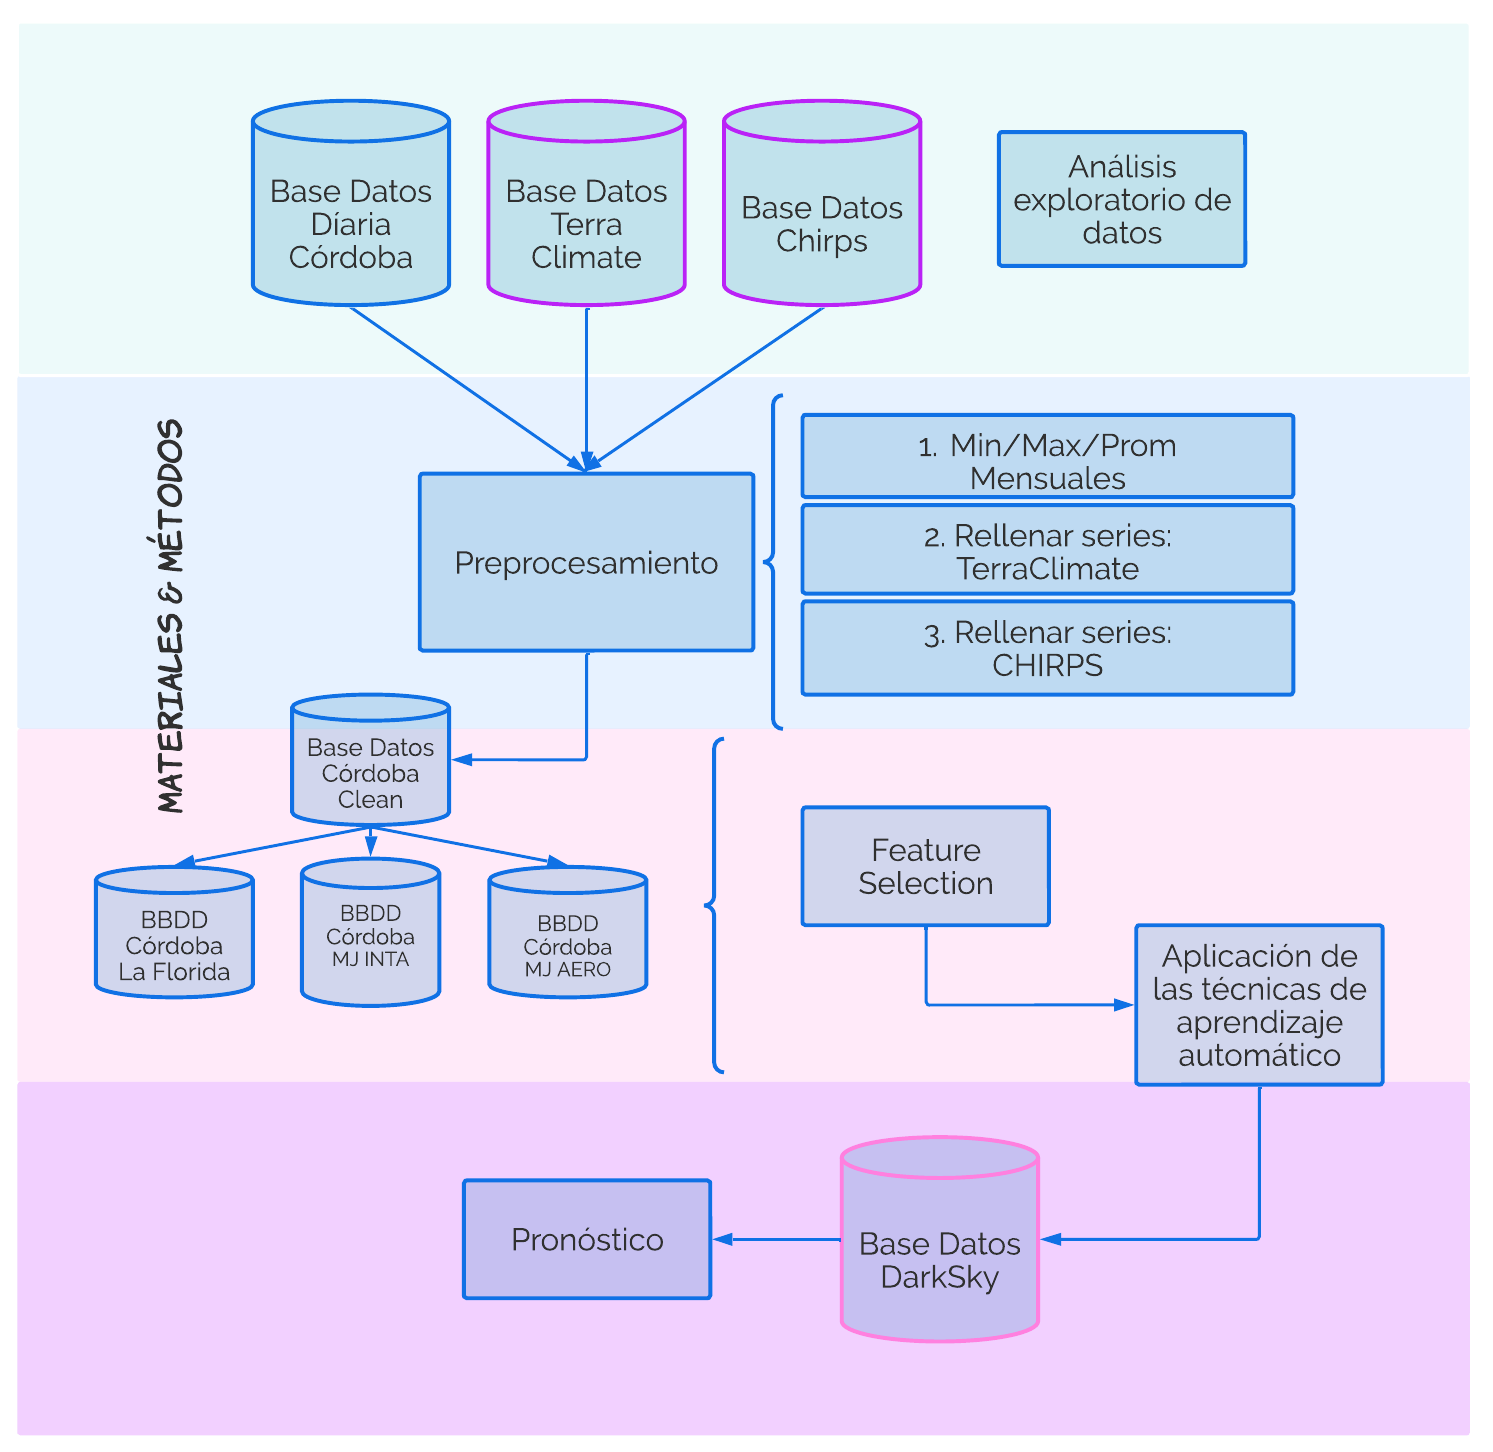

Nota 1:
Previamente construimos algunas bases de datos correspondientes algunas curadas y sin datos ausentes: 

- Marcos Juarez - 87466 - 1967-12-31/2019-05-31 - 600 registros
(omm_id,hydro_year,Date,ETreal_mm,HumedadSuelo_mm,IndicePalmer_porc,RadSolar_Wpm2,helio,hr,hr_max/mes,hr_min/mes,prcp_PMDA,prcp_PTA,pres_est,td,tmax,tmed,tmin,vmax_f,vmed)

- Marcos Juarez - 87467 - 1967-01-31/2020-01-31 - 580 registros (omm_id,hydro_year,Date,helio,hr,hr_max/mes,hr_min/mes,nub,prcp_PMDA,prcp_PTA,pres_est,pres_nm,td,tmax,tmed,tmin,vmax_d,vmax_f,vmed)

- La Florida - 1 - 1958-01-31/2019-12-31 - 709 registros (omm_id,hydro_year,Date,ETreal_mm,HumedadSuelo_mm,IndicePalmer_porc,RadSolar_Wpm2,prcp_PMDA,prcp_PTA,pres_est,tmax,tmed,tmin,vmax_f) 

- Darksky: (omm_id,hydro_year,Date,prcp_PTA,prcp_PMDA,tmax,vmax_f,hr_max/mes,hr,pres_est,tmed,hr_min/mes,tmin)  - 2020-12-31/ para las tres estaciones...

- Una final con todos los registros pero reducida en variables en la que coincidian las tres estaciones... (omm_id,hydro_year,Date,prcp_PMDA,prcp_PTA,pres_est,tmax,tmed,tmin,vmax_f) con 2259 registros. 


      Procedimiento en Python - Imputando Datos:
          








1- Configuración de las librerías necesarías para el desarrollo del trabajo:

In [28]:
import warnings
warnings.filterwarnings("ignore")

## For data
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.25)

## For outliers detection
from sklearn import preprocessing, svm
## For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm

- Carga de datos todas las estaciones incluidos los datos de darksky:

In [29]:
todas = pd.read_csv("https://github.com/argennof/M_Predi_Lluvias_Extremas_10\
/blob/main/BBDD_clean_tc_dc_ch/final_todas_dk.csv?raw=true", sep=',', parse_dates = True)

df = todas.copy()
df.insert(0, 'id', np.arange(len(df)))
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(subset=['prcp_PMDA', 'prcp_PTA'])
df.head(3)

,id,omm_id,hydro_year,Date,prcp_PMDA,prcp_PTA,pres_est,tmax,tmed,tmin,vmax_f
0,0,1,1957,1958-01-31,12.0,37.6,13.79,26.7,19.15,11.6,3.98
1,1,1,1957,1958-02-28,19.3,78.7,14.54,26.3,19.30,12.3,3.95
2,2,1,1957,1958-03-31,159.0,238.9,12.24,22.9,15.90,8.9,4.13


- Confirmamos los datos vacios que nos quedamos solo con los registros completos de PMDA y PTA

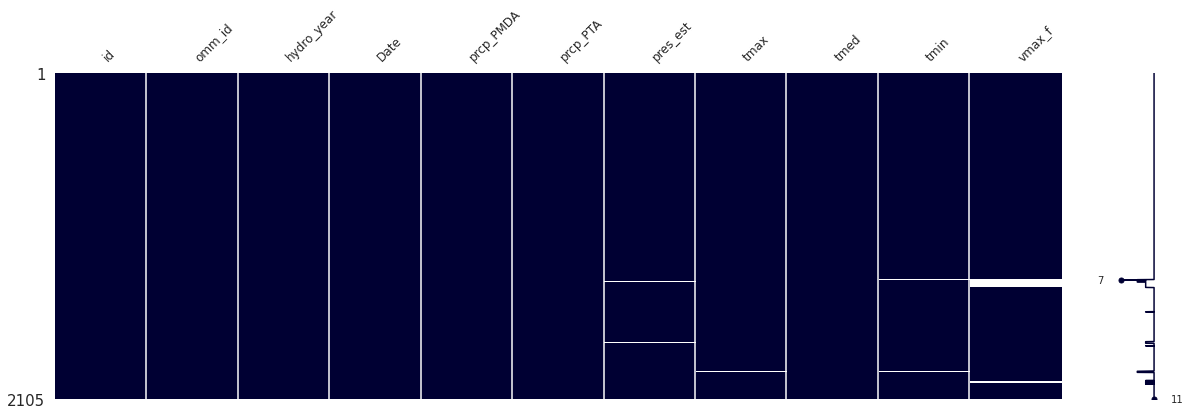

In [30]:
import missingno as msno
msno.matrix(df,figsize=(20, 6), fontsize=12, color=[0,0,0.2])

- Calculo de los valores faltantes:

In [31]:
missing_values_count = df.isna().sum()
missing_values_count.sort_values()

id             0
omm_id         0
hydro_year     0
Date           0
prcp_PMDA      0
prcp_PTA       0
tmed           1
tmax          10
tmin          12
pres_est      20
vmax_f        63
dtype: int64

In [32]:
df.columns

Index(['id', 'omm_id', 'hydro_year', 'Date', 'prcp_PMDA', 'prcp_PTA',
       'pres_est', 'tmax', 'tmed', 'tmin', 'vmax_f'],
      dtype='object')

- Estimamos el porcentaje de datos faltantes y los visualizamos:

In [33]:
# how many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print(f'porcentaje de faltantes en la base de datos: {((total_missing/total_cells) * 100):2f}')

porcentaje de faltantes en la base de datos: 0.457784


- Rellenamos - Imputacion algunas variables:

In [34]:
# Objetos - codigo:
datos_dcor_a = df.loc[:,['omm_id','id','hydro_year', 'Date', 'prcp_PMDA', 'prcp_PTA']]
print(datos_dcor_a.columns)
datos_dcor_num = df.select_dtypes(include=['int', 'float'])
datos_dcor_num.drop(['prcp_PMDA', 'prcp_PTA'], axis=1, inplace=True)
print(datos_dcor_num.columns)

Index(['omm_id', 'id', 'hydro_year', 'Date', 'prcp_PMDA', 'prcp_PTA'], dtype='object')
Index(['id', 'omm_id', 'hydro_year', 'pres_est', 'tmax', 'tmed', 'tmin',
       'vmax_f'],
      dtype='object')


In [35]:
db_1 = datos_dcor_num.query('omm_id == 1')
db_87466 = datos_dcor_num.query('omm_id == 87466')
db_87467 = datos_dcor_num.query('omm_id == 87467')

In [36]:
from sklearn import preprocessing 
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

scaler = preprocessing.RobustScaler()
robust_1 = scaler.fit_transform(db_1)
robust_1 = pd.DataFrame(robust_1, columns=db_1.columns)

imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(),n_nearest_features=5)
values_1 = robust_1.values.copy()

# Matriz escalada
scaled_knn_1 = imputer.fit_transform(values_1)
inver_imputa_1 = pd.DataFrame(scaler.inverse_transform(scaled_knn_1), columns=db_1.columns)

In [37]:
scaler = preprocessing.RobustScaler()
robust_87466 = scaler.fit_transform(db_87466)
robust_87466 = pd.DataFrame(robust_87466, columns=db_87466.columns)

imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(),n_nearest_features=5)
values_87466 = robust_87466.values.copy()

# Matriz escalada
scaled_knn_87466 = imputer.fit_transform(values_87466)
inver_imputa_87466 = pd.DataFrame(scaler.inverse_transform(scaled_knn_87466), columns=db_87466.columns)

In [38]:
from sklearn import preprocessing 

scaler = preprocessing.RobustScaler()
robust_87467 = scaler.fit_transform(db_87467)
robust_87467 = pd.DataFrame(robust_87467, columns=db_87467.columns)

from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(),n_nearest_features=5)
values_87467 = robust_87467.values.copy()
# Matriz escalada
scaled_knn_87467 = imputer.fit_transform(values_87467)
inver_imputa_87467 = pd.DataFrame(scaler.inverse_transform(scaled_knn_87467), columns=db_87467.columns)

In [39]:
# import missingno as msno
# msno.matrix(inver_imputa_1,figsize=(20, 6), fontsize=12, color=[0,0,0.2])
# msno.matrix(inver_imputa_87467,figsize=(20, 6), fontsize=12, color=[0,0,0.2])
# msno.matrix(inver_imputa_87466,figsize=(20, 6), fontsize=12, color=[0,0,0.2])

In [40]:
df_concat = pd.concat([inver_imputa_1,inver_imputa_87466,inver_imputa_87467])

In [41]:
df_concat.reset_index(inplace=True)
df_concat.omm_id =	df_concat.omm_id.astype(int)
df_concat.hydro_year =	df_concat.hydro_year.astype(int)
df_concat.id =	df_concat.id.astype(int)
df_concat.head(2)


,index,id,omm_id,hydro_year,pres_est,tmax,tmed,tmin,vmax_f
0,0,0,1,1957,13.79,26.7,19.15,11.6,3.98
1,1,1,1,1957,14.54,26.3,19.30,12.3,3.95


In [42]:
df_concat.drop(['index'], axis=1, inplace=True)
df_concat.head(1)


,id,omm_id,hydro_year,pres_est,tmax,tmed,tmin,vmax_f
0,0,1,1957,13.79,26.7,19.15,11.6,3.98


In [43]:
datos_dcor_clean = datos_dcor_a.merge(df_concat, on=['id','omm_id','hydro_year'])

In [44]:
datos_dcor_clean.head(3)

,omm_id,id,hydro_year,Date,prcp_PMDA,prcp_PTA,pres_est,tmax,tmed,tmin,vmax_f
0,1,0,1957,1958-01-31,12.0,37.6,13.79,26.7,19.15,11.6,3.98
1,1,1,1957,1958-02-28,19.3,78.7,14.54,26.3,19.30,12.3,3.95
2,1,2,1957,1958-03-31,159.0,238.9,12.24,22.9,15.90,8.9,4.13


In [45]:
datos_dcor_clean.columns

Index(['omm_id', 'id', 'hydro_year', 'Date', 'prcp_PMDA', 'prcp_PTA',
       'pres_est', 'tmax', 'tmed', 'tmin', 'vmax_f'],
      dtype='object')

In [46]:
datos_dcor_clean = datos_dcor_clean.reindex(columns=['id','omm_id','hydro_year', 'Date', 'prcp_PMDA', 'prcp_PTA',
       'pres_est', 'tmax', 'tmed', 'tmin', 'vmax_f'])

- Acumulando los datos:

In [49]:
### Acumulado precipitación - Renombro:
dfg = datos_dcor_clean.copy()
datos_PTA = dfg[['hydro_year','omm_id','prcp_PTA']].groupby(['hydro_year', 'omm_id']).sum()

### Máximos por variable - PMDA - Renombro: 
datos_max = dfg[['hydro_year','omm_id','prcp_PMDA','tmax','vmax_f',\
                                   'pres_est']].groupby(['hydro_year', 'omm_id']).max()

datos_max.rename(columns={'pres_est':'pres_est_max',\
                        },inplace=True)                                   

### Mínimos por variable -  Renombro: 
datos_min = dfg[['hydro_year','omm_id','tmin',
                                   'pres_est']].groupby(['hydro_year', 'omm_id']).min()

datos_min.rename(columns={'tmin':'tmin','pres_est':'pres_est_min'},
                     inplace=True)
                      
### Promedios por variable - Renombro: 
excepto =['id','Date','prcp_PMDA', 'prcp_PTA','tmax','vmax_f','tmin']
datos_prom= round(df.loc[:, df.columns.difference(excepto)
                                                         ].groupby(['hydro_year', 'omm_id']).mean(),2)

datos_prom.rename(columns={ 'pres_est':'pres_est_prom',\
                              'tmed':'tmed'},
                     inplace=True)




In [54]:
# Pegando los dataframe                     
df1= datos_PTA.merge(datos_max, on=['omm_id','hydro_year']) # PTA y maximos
df2 = df1.merge(datos_min, on=['omm_id','hydro_year']) # PTA_maximos y minimos
d_g = df2.merge(datos_prom, on=['omm_id','hydro_year']) # PTA_maximos_minimos_prom
d_g.head(3) 

prcp_PTA  prcp_PMDA  tmax  vmax_f  pres_est_max  tmin  \
omm_id hydro_year                                                          
1      1957           515.2      159.0  26.7    4.13         14.54   2.0   
       1958           612.2       85.0  24.2    5.28         13.55  -1.9   
       1959           762.8       72.0  29.2    4.69         15.22   1.4   

                   pres_est_min  pres_est_prom   tmed  
omm_id hydro_year                                      
1      1957                6.63          11.45  15.34  
       1958                4.58           8.28  12.74  
       1959                6.98          11.03  15.91

Finalmente tenemos la base de datos limpia con esta realizaremos 


    Iniciaremos el procedimiento de Feature Selection.

In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

In [19]:
df1 = datos_dcor_clean.copy()
x = df1[['prcp_PMDA','pres_est', 'tmax', 'tmed', 'tmin', 'vmax_f']]
y_obs1 = df1['prcp_PTA'] 
y_obs2 = df1['prcp_PMDA'] 
x.head(1)


,prcp_PMDA,pres_est,tmax,tmed,tmin,vmax_f
0,12.0,13.79,26.7,19.15,11.6,3.98


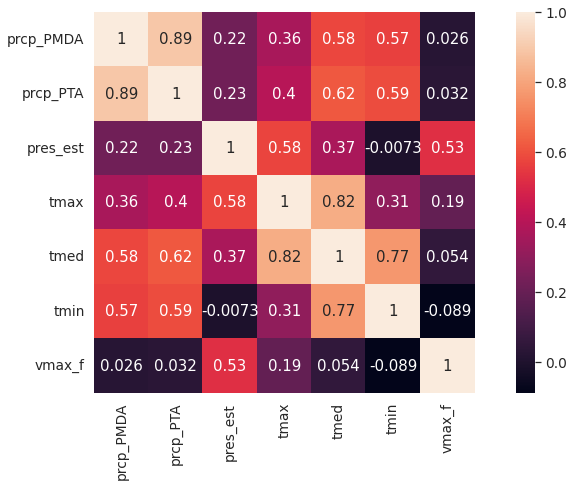

In [20]:
df=df1.loc[:, ['prcp_PMDA', 'prcp_PTA','pres_est', 'tmax', 'tmed', 'tmin', 'vmax_f']]

plt.figure(figsize=(15,7))
sns.heatmap(df.corr(method='spearman'), square = True, annot =True )

In [21]:
# Escalado del conjunto de datos:
scaled_features = x.copy()
col_names = x.columns.tolist()
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [22]:
features

array([[-0.69030345, -0.70774976, -0.17102077,  0.58680694,  1.260656  ,
        -0.65167564],
       [-0.41842657, -0.70614647, -0.22648611,  0.61520962,  1.38300363,
        -0.65534373],
       [ 4.78447756, -0.71106325, -0.6979415 , -0.02858437,  0.78874371,
        -0.63333517],
       ...,
       [-1.13722434, -0.73504858, -0.75479348, -0.20657448,  0.5335615 ,
        -0.76575334],
       [-0.92234478, -0.73504858, -0.80471228, -0.98291429, -0.82974068,
        -0.40297891],
       [-0.99465658, -0.73506995, -0.29581779, -0.55119362, -0.79128856,
        -0.22813313]])

In [ ]:
# control variables:
# print(scaled_features.columns.tolist())
# print(x.columns.tolist())

In [23]:
# X will be a pandas dataframe of all columns except 'f_obs'
x = scaled_features[[col for col in scaled_features.columns]]
# Vector con valores esperados
scaled_features[col_names] = features
scaled_features

,prcp_PMDA,pres_est,tmax,tmed,tmin,vmax_f
0,-0.690303,-0.707750,-0.171021,0.586807,1.260656,-0.651676
1,-0.418427,-0.706146,-0.226486,0.615210,1.383004,-0.655344
2,4.784478,-0.711063,-0.697942,-0.028584,0.788744,-0.633335
3,0.650459,-0.715723,-1.113932,-0.492495,0.456657,-0.684688
4,0.650459,-0.723056,-1.682451,-1.354043,-0.417254,-0.654121
...,...,...,...,...,...,...
2098,-0.923328,-0.735049,-0.808872,-0.984808,-0.824497,-0.407014
2099,-0.992958,-0.735070,-0.299978,-0.551194,-0.791289,-0.228744
2100,-1.137224,-0.735049,-0.754793,-0.206574,0.533562,-0.765753
2101,-0.922345,-0.735049,-0.804712,-0.982914,-0.829741,-0.402979


In [24]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression


from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [25]:
def result_iteracion(features,scores,color,metodo,criterio):

  sn.set(style=color)
  x = features.columns.tolist()
  y = scores
  
  pairs = zip(x, y)
  pairs= sorted(pairs, key=lambda x: x[1], reverse= True)
  plt.xticks(rotation=90)
    
  newx, newy = zip(*pairs)
  
  ax = sn.barplot(x=list(newx), y=list(newy))
  ax.set_title(f'{metodo}',  fontsize = 12)
  plt.ylabel(f'{criterio} Feature Scores')
  plt.show()


  # Almacenando los reportes:
 
  for newx, newy in pairs:
    print(f'score: {newy:0.2f} - var: {newx}')


In [26]:
# Feature selection
KB_fs = SelectKBest(score_func = f_regression, k="all").fit(x, y_obs1)
scores_fr =  KB_fs.scores_


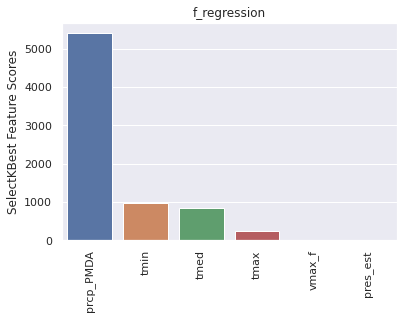

score: 5402.86 - var: prcp_PMDA
score: 987.19 - var: tmin
score: 837.13 - var: tmed
score: 242.65 - var: tmax
score: 7.45 - var: vmax_f
score: 0.89 - var: pres_est


In [27]:
#show_results(x, scores)
# Aplicando la funcion 
result_iteracion(x,scores_fr,color = "darkgrid", metodo = 'f_regression', criterio ='SelectKBest')

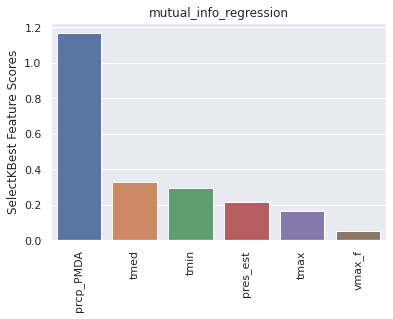

score: 1.17 - var: prcp_PMDA
score: 0.33 - var: tmed
score: 0.29 - var: tmin
score: 0.22 - var: pres_est
score: 0.17 - var: tmax
score: 0.05 - var: vmax_f


In [ ]:
# los métodos de información mutua pueden capturar cualquier tipo de dependencia estadística, 
# pero al no ser paramétricos, requieren más muestras para una estimación precisa.

KB_fs_mr  = SelectKBest(score_func=mutual_info_regression, k="all").fit(x, y_obs1)
scores_mr =  KB_fs_mr .scores_
# Aplicando la funcion 

result_iteracion(x,scores_mr,color = "darkgrid", metodo = 'mutual_info_regression', criterio ='SelectKBest')

In [ ]:
# fig, axes = plt.subplots(5,2,figsize=(14, 30), dpi=100)

# for i, col_name in enumerate(x.columns[2:]):
#     if train_all_lvls[col_name].dtype == 'O':
#         train_all_lvls.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.6);
#         axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]);
#     else:
#         train_all_lvls.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
#         axes[i%5][i//5].legend();
#     axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
#     plt.subplots_adjust(hspace=0.45)

In [ ]:
ts = dtf.groupby("date")["item_cnt_day"].sum().rename("sales")
ts.head()

In [ ]:
print("population --> len:", len(ts), "| mean:", round(ts.mean()), " | std:", round(ts.std()))
w = 30
print("moving --> len:", w, " | mean:", round(ts.ewm(span=w).mean()[-1]), " | std:", round(ts.ewm(span=w).std()[-1]))

Aca inicia:
- https://towardsdatascience.com/time-series-analysis-for-machine-learning-with-python-626bee0d0205

- https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/blob/master/time_series/example_forecast.ipynb